# Hugging Face Library 'Transformer'およびT5Tokenizerのダウンロード

参考(https://qiita.com/takubb/items/fd972f0ac3dba909c293)これを基に改造し、最新のGoogle Colaboratoryで動作するようにした

In [1]:
!pip install transformers
!apt install swig
# Sentencepieceのインストール
!pip install sentencepiece
from transformers import T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained("rinna/japanese-roberta-base")
tokenizer.do_lower_case = True  # due to some bug of tokenizer config loading

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


# PyTorchとGPU設定

In [2]:
!pip install torch
import torch
# GPUが使えれば利用する設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# データセットの準備

ライブドアニュースコーパスをダウンロード

    ダウンロードしたファイルは圧縮（tar.gz形式）ファイル
    様々なジャンル（IT,スポーツ,家電,映画など）のWEBメディアごとにフォルダに記事がテキストファイルで保存されている
    
以下、ファイルを読み込んで、必要な部分を抽出

In [3]:
import os
import re
import csv
import glob
import MeCab
import warnings
import numpy as np
warnings.filterwarnings('ignore')
#urllib.request.urlretrieve("https://www.rondhuit.com/download/ldcc-20140209.tar.gz", "ldcc-20140209.tar.gz")
# ダウンロードした圧縮ファイルのパスを設定
#tgz_fname = "ldcc-20140209.tar.gz" 
# 2つをニュースメディアのジャンルを選定
mydata = '/export/livedoor' 
#処理をした結果を保存するファイル名 
tsv_fname = "all_text.tsv" 

def remove_brackets(inp):
    output = re.sub(u'[〃-〿]', '',(re.sub('＝|=|×|\(|\)|“|”|（|）|／|\[|\]| |　|…|・|\n|\t|/|＜|＞|@|＠', '', re.sub(u'[ℊ-⿻]', '', inp)))) #210A ~ 2FFF
    return output

"""
def read_url(f):
    url = next(f)
    return url[:-1]

def read_date(f):
    date = next(f)
    date = remove_brackets(date.encode().decode('utf-8'))
    return date[:-1]
"""

def read_title(f):
    next(f)
    next(f)
    title = next(f)
    title = remove_brackets(title.encode().decode('utf-8'))
    return title[:-1]

def read_para(f):
    p = ''
    while True:
        try:
            para = next(f)
            para = remove_brackets(para.encode().decode('utf-8'))
            p += para
        except StopIteration:
            break
    return p [:-1]

In [4]:
#directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/it-life-hack']
#target_genre = ["dokujo-tsushin", "it-life-hack"] 
directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/peachy']
target_genre = ["dokujo-tsushin", "peachy"] 
zero_fnames = []
one_fnames = []

if os.path.exists(tsv_fname) == True:
    with open(tsv_fname, "r+") as f:
        f.truncate(0)

for i in range(2):
    for filename in os.listdir(directory[i]):
        if "LICENSE.txt" in filename:
            continue
        f = os.path.join(directory[i], filename)
        #if os.path.isfile(f):
        #    print(f)
        if target_genre[0] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[0], '0', title, para]
                    writer.writerow(row)
            continue
        if target_genre[1] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[1], '1', title, para]
                    writer.writerow(row)
            continue

pandasでデータを読み込み

In [5]:
import pandas as pd
# データの読み込み
df = pd.read_csv("all_text.tsv", 
                 delimiter='\t', header=None, names=['media_name', 'label','title','sentence'])
# データの確認
print(f'データサイズ： {df.shape}')
df.sample(10)

データサイズ： (1712, 4)


,media_name,label,title,sentence
552,dokujo-tsushin,0,結婚は？子どもは？母の説教スルー,で、アンタはいつ結婚するつもりなの？早く子ども産んでおかないと、あとが大変よ年末年始、久しぶ...
1339,peachy,1,エコ活動しながらお相手探し！クリーンアップ婚活イベント開,"ゴルフ婚活や料理婚活など、ただ食事やお酒を共にするだけでは無く、イベント性をプラスした""婚活..."
448,dokujo-tsushin,0,女が求める成長できる恋と,バラエティ番組で、あるお笑い芸人が、こんなことを言っていた。好きなタイプは私を成長させてくれ...
1308,peachy,1,危険な女を傷つける男の特徴束縛が強そうな血液型は？など恋愛週間ランキン,Peachyでも大人気の恋愛をテーマにした記事の週間ランキングです！2012年4月2日4月8...
1351,peachy,1,女性のNGな外見1位は寝る直前にやってはいけないことなどビューティ週間ランキン,美しさを追求するのは、女子の永遠の課題と言っても過言ではありません。ファッションビューティカ...
1506,peachy,1,年末のホームパーティに大活躍！1プッシュでピカピカキッチンを手に入れよ,シチューやスープを作って彼にふるまったり、女友達と鍋パーティを開催したり、何かとお部屋に人を...
647,dokujo-tsushin,0,通えば結婚できる？結婚予備校ってどんなところ,初めて婚活に勝てる学校出来ました！ふと、ネット上でそんなキャッチフレーズを見かけたのでクリッ...
594,dokujo-tsushin,0,女医が教えるオンナの体ウソホントvol.5どうしたらＨが気持ちよくなるの,感度を高めたいけれどどうすればいいですか？これ、たまに聞かれるのよねぇ。性感って日常的なもの...
155,dokujo-tsushin,0,キスシーンだらけのDVD、あなたはウットリしますか,最近、独女を中心に人気を集めているというBRIGHTキスkissキスというDVDをご存知だろ...
143,dokujo-tsushin,0,いま話題のフレンチトースト！きな粉＆黒蜜味に、明太マヨ味,このところ、朝夕の情報番組や雑誌などでも注目されているフレンチトースト。江ノ島のLONCAF...


//文章データをsentences、ラベルデータを labelsに保存、以降この2変数だけを利用

In [6]:
mn = df.media_name.values
labels = df.label.values
titles = df.title.values
sentences = df.sentence.values

# Moji suu shitei

In [7]:
tagger = MeCab.Tagger("-Owakati")

def make_wakati(sentence):
  # MeCabで分かち書きを行う
    sentence = tagger.parse(sentence)
  # 半角全角英数字などは削除する
#    sentence = re.sub(r'[0-9０-９a-zA-Zａ-ｚＡ-Ｚ]+', " ", sentence)
  # 記号なども削除する
#    sentence = re.sub(r'[\．_－―─！＠＃＄％＾＆\-‐|\\＊\“（）＿■×+α※÷⇒—●★☆〇◎◆▼◇△□(：〜～＋=)／*&^%$#@!~`){}［］…\[\]\"\'\”\’:;<>?＜＞〔〕〈〉？、。・,\./『』【】「」→←○《》≪≫\n\u3000]+', "", sentence)
  # スペース区切で形態素の配列に変換する
    wakati = sentence.split(" ")
  # 空要素を削除する
    wakati = list(filter(("").__ne__, wakati))
    return wakati

In [8]:
wakati_sentences = []

for i in range(len(sentences)):
    wakati_sentences.append(make_wakati(sentences[i]))

In [9]:
wcount = 128

h_sentences = []
t_sentences = []

# wcount moji me kara kesu

for i in enumerate(wakati_sentences):
    #h_sent = []
    h_len = 0
    hn = 0
    #h_sent.append(wakati_sentences[i[0]][0])
    h_len += len(wakati_sentences[i[0]][0])
    while h_len < wcount:
        try:
            hn += 1
            if wakati_sentences[i[0]][hn]:
                #print(hn, wakati_sentences[i[0]][hn])
                #h_sent.append(wakati_sentences[i[0]][hn])
                h_len += len(wakati_sentences[i[0]][hn])
        except IndexError:
            break
    h_sentences.append(sentences[i[0]][:hn])
    
    #t_sent = []
    t_len = 0
    tn = 2
    #t_sent.append(wakati_sentences[i[0]][-2])
    t_len += len(wakati_sentences[i[0]][-2])
    while t_len < wcount:
        try:
            tn += 1
            if wakati_sentences[i[0]][tn]:
                #print(tn, wakati_sentences[i[0]][tn])
                #t_sent.append(wakati_sentences[i[0]][tn])
                t_len += len(wakati_sentences[i[0]][tn])
        except IndexError:
            break
    t_sentences.append(sentences[i[0]][-tn:])

'''
    
    if i[0] == 5:
        print(h_sentences)
        break



        
    if len(i[1])>wcount:
        h_sentences.append(sentences[i[0]][:wcount])
    else:
        h_sentences.append(sentences[i[0]])

        
# ushiro kara wcount moji toru

for i in enumerate(sentences):
    if len(i[1])>wcount:
        t_sentences.append(sentences[i[0]][-wcount:])
    else:
        t_sentences.append(sentences[i[0]])
'''

'\n    \n    if i[0] == 5:\n        print(h_sentences)\n        break\n\n\n\n        \n    if len(i[1])>wcount:\n        h_sentences.append(sentences[i[0]][:wcount])\n    else:\n        h_sentences.append(sentences[i[0]])\n\n        \n# ushiro kara wcount moji toru\n\nfor i in enumerate(sentences):\n    if len(i[1])>wcount:\n        t_sentences.append(sentences[i[0]][-wcount:])\n    else:\n        t_sentences.append(sentences[i[0]])\n'

In [10]:
hsentences = np.array(h_sentences)
tsentences = np.array(t_sentences)

# BERT Tokenizerを用いて単語分割・IDへ変換
## Tokenizerの準備
単語分割とIDへ変換

# テスト実行

In [11]:
# 元文章
print(' Original: ', sentences[0])
# Tokenizer
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
# Token-id
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  両親や親族が高齢なってくると、自分の人生を見つめ直さないといけないことがある。自分が独女の場合はなお更である。今回の相談者ミミさん女性38歳は母親が介護が必要になったことを機に働き方を変えたのだが、以降、仕事や人間関係がうまく築けずに悩み続けている。同時に、現在結婚していないことで将来に大きな不安も抱いている。この先、希望を見出すことは出来るのだろうか？霊感鑑定で定評のある占い師翔生先生に鑑定してもらった。占い師翔生先生nifty電話占いメール占い相談内容母の介護が必要になった頃から今までずっと社会から離れ、自宅にこもっているような状態が続いています。母は5年前に亡くなったのですが、それ以前から現在まで時、バイトなどをしているだけで、仕事が決まっても内容が合わなかったり、内定後、仕事先に行ってみると社内の雰囲気が悪かったりと長くは続かず、短期派遣を時折していました。しかし最近は、派遣の仕事さえも決まらず家にずっといるだけの状態になっています。父も高齢になってきており、一人っ子のため、先の事を考えると不安になります。友人も結婚したり、地方に引越したりと付き合いも無くなってきており、母の知人や派遣先で知り合った知人達とはメールでの連絡はとっていたのですが、最近はそんなメールも中止して欲しいと連絡してしまいました。親しくしていた母の親戚とも葬儀後、距離が出てしまい、父方の親戚とも連絡をとっていないため、先の事を考えると本当に不安です。こんな状況がずっと続いているのですが、今後、運命が変わる時は訪れるのでしょうか？鑑定結果はじめましてミミさん。占い師の翔生と申します。早速鑑定してみましょう。2007年の頃よりずっと、あなたは閉鎖的になってしまったようですね。これまでのあなたの努力は、誰にも真似できないほど頑張っていたに違いありません。お母様は深く感謝しておられます。お母様が今でもあなたに感謝しているのはあなたの努力あっての事とお察しします。その当時のあなたはとても精神的に辛く、肉体的にも疲れていた事でしょう。肉親との別れもあって、精神的に燃え尽きてしまった感触があります。その結果、誰かに意見されても、頑張ってきたという気持ちがあるせいか、周りの意見を遮断してしまいがちです。指図されたくない感情の方が優先されてしまうこれからの方向性にも、運勢上その傾向

In [12]:
# 最大単語数の確認
max_len = []
# 1文づつ処理
for sent in sentences:
    # Tokenizeで分割
    token_words = tokenizer.tokenize(sent)
    # 文章数を取得してリストへ格納
    max_len.append(len(token_words))
# 最大の値を確認
print('最大単語数: ', max(max_len))
print('上記の最大単語数にSpecial token（[CLS], [SEP]）の+2をした値が最大単語数')

最大単語数:  2879
上記の最大単語数にSpecial token（[CLS], [SEP]）の+2をした値が最大単語数


In [13]:
h_input_ids = []
t_input_ids = []
h_attention_masks = []
t_attention_masks = []

# 1文づつ処理
for sent in hsentences:
    hencoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, # Special Tokenの追加
                        max_length = wcount+2,  # I think maximum 文章の長さを固定（Padding/Trancatinating）
                        truncation=True,                
                        pad_to_max_length = True,# PADDINGで埋める
                        return_attention_mask = True,   # Attention maksの作成
                        return_tensors = 'pt',     #  Pytorch tensorsで返す
                   )
    # print(hencoded_dict)

    h_input_ids.append(hencoded_dict['input_ids'])
    h_attention_masks.append(hencoded_dict['attention_mask'])
    
for sent in tsentences:
    tencoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, # Special Tokenの追加
                        max_length = wcount+2,  # I think maximum 文章の長さを固定（Padding/Trancatinating）
                        truncation=True,                
                        pad_to_max_length = True,# PADDINGで埋める
                        return_attention_mask = True,   # Attention maksの作成
                        return_tensors = 'pt',     #  Pytorch tensorsで返す
                   )
    # https://qiita.com/YuiKasuga/items/343309257da1798c1b63

    # 単語IDを取得    
    t_input_ids.append(tencoded_dict['input_ids'])

    # Attention　maskの取得
    t_attention_masks.append(tencoded_dict['attention_mask'])

# リストに入ったtensorを縦方向（dim=0）へ結合
h_input_ids = torch.cat(h_input_ids, dim=0)
t_input_ids = torch.cat(t_input_ids, dim=0)
h_attention_masks = torch.cat(h_attention_masks, dim=0)
t_attention_masks = torch.cat(t_attention_masks, dim=0)

# tenosor型に変換
labels = torch.tensor(labels)

# 確認
print('Original: ', hsentences[0])
print('Original: ', tsentences[0])
print('Token IDs:', h_input_ids[0])
print(type(labels), labels)
print(torch.Tensor.size(h_input_ids))
print(torch.Tensor.size(h_attention_masks))
print(torch.Tensor.size(labels))
print(hsentences.size)

Original:  両親や親族が高齢なってくると、自分の人生を見つめ直さないといけないことがある。自分が独女の場合はなお更である。今回の相談者ミミさん女性38歳は母親が介護が必要になった
Original:  話占いメール占いでは霊感鑑定はもちろん、タロットから運勢の流れを読み解き、また、夢分析から近未来を予測します。関連サイトnifty電話占いメール占い翔生先生プロフィー
Token IDs: tensor([    9,  3652,    26, 13508,    12, 19860,    57,  9123,    20,     7,
         1393,  4221,  1429, 15133,   442,  4569,    20, 19133,  1272,     8,
         5144,  2596,   612,  2855,  3244, 13426,    27,     8, 16058,  5448,
          147,   318,   318,   774,   577,  1300,   559,    11,  4180,    12,
        12079,  3413,   344,     2,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     

In [14]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torchvision import transforms, datasets
from transformers import RobertaForMaskedLM

# データセットクラスの作成
# dataset = TensorDataset(h_input_ids, h_attention_masks, labels)
hdataset = TensorDataset(h_input_ids, h_attention_masks, labels)
tdataset = TensorDataset(t_input_ids, t_attention_masks, labels)
# dataset = CustomTensorDataset(tensors = (input_ids, labels), transform = None)


In [15]:
# 80%地点のIDを取得
num_dataset = len(hdataset)
#train_size = int(0.1 * num_dataset)
#val_size = num_dataset - train_size

train_size = int(0.9 * len(hdataset))
val_size = len(hdataset) - train_size

# データセhttp://localhost:8888/notebooks/bert-zuco/augmentation/BERTclassification-mydata-local-augmentation-aug.ipynb#ットを分割
h_train_dataset, h_val_dataset = random_split(hdataset, [train_size, val_size])
t_train_dataset, t_val_dataset = random_split(tdataset, [train_size, val_size])

print('訓練データ数:{}'.format(train_size))
print('検証データ数:{}'.format(val_size))

# データローダーの作成
batch_size = 32

'''
data_transform = transforms.Compose([
    synreplace(1),
    randinsert(3),
    randdelete(0.15), 
    randswap(2)
])


class MySubset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __getitem__(self, idx):
        xa, mask, label = self.dataset[self.indices[idx]]
        if self.transform:
            xa = self.transform(xa)
        return xa, mask, label

    def __len__(self):
        return len(self.indices)
    
indices = np.random.choice(num_dataset, num_dataset, replace=False)



h_train_dataset = MySubset(hdataset, indices[:train_size], data_transform)
h_val_dataset = MySubset(hdataset, indices[train_size:])
t_train_dataset = MySubset(tdataset, indices[:train_size], data_transform)
t_val_dataset = MySubset(tdataset, indices[train_size:])

'''

# 訓練データローダー
h_train_dataloader = DataLoader(
            h_train_dataset,  
            sampler = RandomSampler(h_train_dataset), # ランダムにデータを取得してバッチ化
            batch_size = batch_size
            )
t_train_dataloader = DataLoader(
            t_train_dataset,
            sampler = RandomSampler(t_train_dataset), # ランダムにデータを取得してバッチ化
            batch_size = batch_size
            )



# 検証データローダー
h_validation_dataloader = DataLoader(
            h_val_dataset, 
            sampler = SequentialSampler(h_val_dataset), # 順番にデータを取得してバッチ化
            batch_size = batch_size
        )
t_validation_dataloader = DataLoader(
            t_val_dataset, 
            sampler = SequentialSampler(t_val_dataset), # 順番にデータを取得してバッチ化
            batch_size = batch_size
        )

訓練データ数:1540
検証データ数:172


In [16]:
from transformers import BertForSequenceClassification,AdamW,BertConfig

# BertForSequenceClassification 学習済みモデルのロード
h_model = BertForSequenceClassification.from_pretrained(
    "cl-tohoku/bert-base-japanese-whole-word-masking", # 日本語Pre trainedモデルの指定
    num_labels = 2, # ラベル数（今回はBinaryなので2、数値を増やせばマルチラベルも対応可）
    output_attentions = False, # アテンションベクトルを出力するか
    output_hidden_states = False, # 隠れ層を出力するか
)

t_model = BertForSequenceClassification.from_pretrained(
    "cl-tohoku/bert-base-japanese-whole-word-masking", # 日本語Pre trainedモデルの指定
    num_labels = 2, # ラベル数（今回はBinaryなので2、数値を増やせばマルチラベルも対応可）
    output_attentions = False, # アテンションベクトルを出力するか
    output_hidden_states = False, # 隠れ層を出力するか
)

# モデルをGPUへ転送
h_model.cuda()
t_model.cuda()

2022-11-07 00:07:47.206942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-07 00:07:47.325747: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-07 00:07:47.650569: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-07 00:07:47.650616: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [17]:
# 最適化手法の設定
h_optimizer = AdamW(h_model.parameters(), lr=2e-5)

# 訓練パートの定義
def h_train(h_model):
    h_model.train() # 訓練モードで実行
    h_train_loss = 0
    for batch in h_train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        h_optimizer.zero_grad()
        outputs = h_model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(h_model.parameters(), 1.0)
        h_optimizer.step()
        h_train_loss += loss.item()
    return h_train_loss


# テストパートの定義
def h_validation(h_model):
    h_model.eval()# 訓練モードをオフ
    h_val_loss = 0
    with torch.no_grad(): # 勾配を計算しない
        for batch in h_validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            with torch.no_grad():        
                (loss, logits) = h_model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
            h_val_loss += loss.item()
    return h_val_loss


In [18]:
t_optimizer = AdamW(t_model.parameters(), lr=2e-5)

def t_train(t_model):
    t_model.train() # 訓練モードで実行
    t_train_loss = 0
    for batch in t_train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        t_optimizer.zero_grad()
        outputs = t_model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(t_model.parameters(), 1.0)
        t_optimizer.step()
        t_train_loss += loss.item()
    return t_train_loss

def t_validation(t_model):
    t_model.eval()# 訓練モードをオフ
    t_val_loss = 0
    with torch.no_grad(): # 勾配を計算しない
        for batch in t_validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            with torch.no_grad():        
                (loss, logits) = t_model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
            t_val_loss += loss.item()
    return t_val_loss

In [19]:
# 学習の実行
max_epoch = 50
t_train_loss_ = []
t_test_loss_ = []
h_train_loss_ = []
h_test_loss_ = []

h_train_loss = 0
t_train_loss = 0

for epoch in range(max_epoch):
    h_train_ = h_train(h_model)
    h_test_ = h_train(h_model)
    h_train_loss_.append(h_train_)
    h_test_loss_.append(h_test_)

In [20]:
h_model.train() # 訓練モードで実行
h_test_accuracy = []

for epoch in range(max_epoch):
    h_train_ = h_train(h_model)
    h_test_ = h_train(h_model)
    h_train_loss_.append(h_train_)
    h_test_loss_.append(h_test_)

for batch in h_train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
#    b_input_ids = batch[0].to(device)
#    b_input_mask = batch[1].to(device)
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = torch.t(batch[2]).to(device)
    h_optimizer.zero_grad()
    outputs = h_model(b_input_ids, 
                         token_type_ids=None, 
                         attention_mask=b_input_mask, 
                         labels=b_labels)
    h_loss = outputs.loss
    h_loss.backward()
    torch.nn.utils.clip_grad_norm_(h_model.parameters(), 1.0)
    h_optimizer.step()
    h_train_loss += h_loss.item()

h_model.eval()# 訓練モードをオフ

for batch in h_validation_dataloader:
    #print(batch)
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    #print(len(b_labels))
    with torch.no_grad():   
        # 学習済みモデルによる予測結果をpredsで取得     
        h_preds = h_model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        h_test_accuracy.append((torch.argmax(h_preds[0], 1) == b_labels).sum().item() / len(b_labels))


In [21]:
for epoch in range(max_epoch):
    t_train_ = t_train(t_model)
    t_test_ = t_train(t_model)
    t_train_loss_.append(t_train_)
    t_test_loss_.append(t_test_)

t_model.train() # 訓練モードで実行
t_test_accuracy = []

for batch in t_train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
#    b_input_ids = batch[0].to(device)
#    b_input_mask = batch[1].to(device)
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = torch.t(batch[2]).to(device)
    t_optimizer.zero_grad()
    outputs = t_model(b_input_ids, 
                         token_type_ids=None, 
                         attention_mask=b_input_mask, 
                         labels=b_labels)
    t_loss = outputs.loss
    t_loss.backward()
    torch.nn.utils.clip_grad_norm_(t_model.parameters(), 1.0)
    t_optimizer.step()
    t_train_loss += t_loss.item()
    
t_model.eval()# 訓練モードをオフ

for batch in t_validation_dataloader:
    #print(batch)
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    #print(len(b_labels))
    with torch.no_grad():   
        # 学習済みモデルによる予測結果をpredsで取得     
        t_preds = t_model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        t_test_accuracy.append((torch.argmax(t_preds[0], 1) == b_labels).sum().item() / len(b_labels))

        #print('preds: ', torch.argmax(preds[0], 1))
        #print('b_labels: ', b_labels)

In [22]:
len(t_preds[0])

12

In [23]:
import statistics

print(statistics.mean(h_test_accuracy))
print(statistics.mean(t_test_accuracy))

0.7586805555555556
0.9427083333333334


In [24]:
h_pred_df = pd.DataFrame(np.argmax(h_preds[0].cpu().numpy(), axis=1), columns=['h_pred_label'])
t_pred_df = pd.DataFrame(np.argmax(t_preds[0].cpu().numpy(), axis=1), columns=['t_pred_label'])
label_df = pd.DataFrame(b_labels.cpu().numpy(), columns=['true_label'])
accuracy_df = pd.concat([h_pred_df, t_pred_df, label_df], axis=1)
accuracy_df

,h_pred_label,t_pred_label,true_label
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
5,1,0,0
6,0,1,1
7,0,1,1
8,1,0,0
9,1,1,1


In [25]:
a = torch.randn(4, 4)
print(a)
print(torch.argmax(a))

tensor([[ 0.2457,  0.9831, -0.4681, -0.3138],
        [-1.5677, -0.5288,  1.3367,  0.1258],
        [-0.1399,  0.2467,  0.4834,  2.1717],
        [-0.6775,  1.0614,  0.8795,  0.4909]])
tensor(11)


In [26]:
'''
correct = 0
test_accuracy = 0

p_list = []
l_list = []

p_list = pred_df.values.tolist()
l_list = label_df.values.tolist()

#print(type(pred_df))

for i in range(len(b_labels)):
    if(p_list[i] == l_list[i]):
        correct += 1

test_accuracy = correct/len(b_labels)

print(test_accuracy)
'''

'\ncorrect = 0\ntest_accuracy = 0\n\np_list = []\nl_list = []\n\np_list = pred_df.values.tolist()\nl_list = label_df.values.tolist()\n\n#print(type(pred_df))\n\nfor i in range(len(b_labels)):\n    if(p_list[i] == l_list[i]):\n        correct += 1\n\ntest_accuracy = correct/len(b_labels)\n\nprint(test_accuracy)\n'

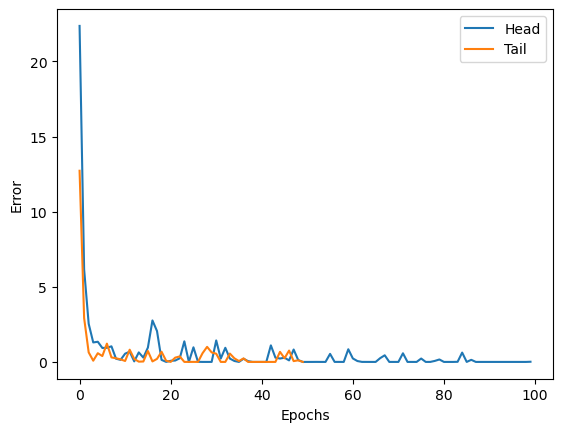

In [27]:
import matplotlib.pyplot as plt

plt.plot(range(len(h_test_loss_)), h_test_loss_, label="Head")
plt.plot(range(len(t_test_loss_)), t_test_loss_, label="Tail")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()  # ラベルがあるときは、きちんとplt.show()を呼び出すこと